## Descripción del Proceso de Generación de Imágenes

Este documento describe el proceso utilizado para generar el dataset de imágenes, centrándose en la simulación de aberraciones ópticas mediante Coeficientes de Zernike y su representación a través del método de Hartmann-Shack.

### 1. Coeficientes de Zernike

Los Coeficientes de Zernike son una serie de polinomios ortogonales utilizados comúnmente en óptica para describir las aberraciones de un frente de onda. En este dataset, cada imagen es generada a partir de un conjunto de **20 coeficientes de Zernike**.

*   **Número de Coeficientes:** Se utilizan los primeros 20 coeficientes de Zernike (excluyendo el pistón, que solo representa un cambio de fase global y no afecta la forma de la imagen).
*   **Rango de Valores:** Cada uno de estos 20 coeficientes de Zernike varía dentro de un rango de **-8 a 8 micrometros**.
    *   Este rango permite simular una amplia variedad de aberraciones, desde las más comunes (como el desenfoque y el astigmatismo) hasta las de orden superior, capturando la complejidad de los frentes de onda que se encuentran en sistemas ópticos reales o en el ojo humano.
    *   La variabilidad de los coeficientes asegura una diversidad en el dataset, crucial para entrenar modelos robustos de aprendizaje automático.

### 2. Método de Simulación Hartmann-Shack

La generación de las imágenes se realiza mediante la simulación de un **sensor de frente de onda Hartmann-Shack**. Este método es fundamental para la caracterización de las aberraciones:

*   **Principio:** Un sensor Hartmann-Shack consiste en una matriz de microlentes que dividen el frente de onda incidente en múltiples pequeños sub-aperturas. Cada microlente enfoca la luz en un punto en un detector (por ejemplo, un CCD).
*   **Detección de Aberraciones:** Si el frente de onda es plano y perfecto, todos los puntos focales de las microlentes formarán una cuadrícula regular. Sin embargo, en presencia de aberraciones, los puntos focales se desplazan de sus posiciones ideales. La magnitud y dirección de estos desplazamientos son directamente proporcionales a la pendiente local del frente de onda.
*   **Generación de Imágenes:** En esta simulación, los 20 coeficientes de Zernike definen un frente de onda aberrado. Este frente de onda es entonces "medido" virtualmente por un sensor Hartmann-Shack simulado. La salida de esta simulación es una imagen que representa los desplazamientos de los spots focales, que es la imagen que compone el dataset.

### Resumen del Proceso

1.  Se seleccionan aleatoriamente 20 coeficientes de Zernike, cada uno dentro del rango [-1, 1].

2. Los coeficientes 1 y 2 varian entre -17 y 17 micrómetros generados aleatoriamente, el coeficiente 0 no se toma puesto que no aporta información relevante.
3.  Estos coeficientes definen un frente de onda con aberraciones específicas.
4.  Se simula cómo un sensor Hartmann-Shack "vería" 4ste frente de onda aberrado.
5.  La salida de esta simulación (la imagen de los spots desplazados) se guarda como una entrada en el dataset.

Este enfoque permite crear un dataset diverso y representativo de frentes de onda con aberraciones conocidas y también se crea una cantida de imágines específica para garantizar un rango dinámico amplo para ser evaluado, lo que es ideal para entrenar y evaluar modelos capaces de predecir o clasificar aberraciones ópticas a partir de imágenes de Hartmann-Shack.

### Instalación de Librerías

Este bloque de código se encarga de instalar todas las librerías necesarias para el proyecto. Utiliza `pip install --quiet` para una instalación silenciosa de paquetes como `numpy`, `pandas`, `pillow`, `matplotlib`, `tqdm`, `scipy` (para correlación de Pearson), `scikit-learn` (para MAE, R2), `plotly` (para gráficas interactivas) y las dependencias de `PyTorch` (`torch`, `torchvision`, `torchaudio`) compatibles con CUDA. También instala `gdown` para la descarga desde Google Drive. Al finalizar, imprime un mensaje de confirmación.

In [1]:
# ============================================================
# 🔧 Instalación de todas las librerías necesarias (Colab)
# ============================================================

# Básicos
!pip install --quiet numpy pandas pillow matplotlib tqdm numpy

# SciPy (para correlación Pearson)
!pip install --quiet scipy

# Scikit-Learn (MAE, R2)
!pip install --quiet scikit-learn

# Plotly (gráficas interactivas)
!pip install --quiet plotly

# PyTorch + TorchVision compatible con CUDA (Colab)
# Colab ya incluye PyTorch, pero forzamos actualización estable.
!pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

!pip install gdown
print("Todas las dependencias han sido instaladas correctamente.")


Todas las dependencias han sido instaladas correctamente.


### Importación de Librerías

Este bloque importa todas las librerías y módulos que se utilizarán a lo largo del notebook. Incluye módulos para:
- **Manejo de archivos y rutas**: `os`, `zipfile`, `gdown`, `re`.
- **Manipulación de datos numéricos y estructuras**: `numpy` (como `np`), `PIL` (como `Image`), `pandas` (como `pd`), `random`.
- **Estadísticas y métricas**: `scipy.stats` (para correlación de Pearson), `sklearn.metrics` (para MAE, R2).
- **PyTorch**: `torch`, `torch.nn`, `torch.nn.functional` (como `F`), `torch.optim`, `torch.utils.data` (`Dataset`, `DataLoader`).
- **Procesamiento de imágenes**: `torchvision.transforms` (como `transforms`), `torchvision.transforms.ToPILImage`, `torchvision.models.feature_extraction.create_feature_extractor`.
- **Visualización**: `tqdm` (para barras de progreso), `matplotlib.pyplot` (como `plt`), `plotly.express` (como `px`), `plotly.graph_objects` (como `go`), `plotly.subplots.make_subplots`.

In [2]:
import os
import zipfile
import gdown
import re

import numpy as np
from PIL import Image
import pandas as pd
import random


import scipy.stats as stats  # Para calcular la correlación de Pearson
from sklearn.metrics import mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from torchvision.models.feature_extraction import create_feature_extractor

from tqdm import tqdm  # Para mostrar el progreso

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### Descarga de Datos desde Google Drive

Este bloque define un `folder_id` de Google Drive y construye una URL para la descarga. Luego, utiliza la librería `gdown` para descargar la carpeta completa especificada por la URL. La descarga se guarda en el directorio `./data` dentro del entorno de Colab. Al finalizar, muestra un mensaje de confirmación de la descarga.

In [3]:
folder_id = "14--HWvqgHGtH5TVJu3sqSGAp2tEYTsYi"
url = f"https://drive.google.com/drive/folders/{folder_id}"

print("Descargando carpeta desde Google Drive...")
gdown.download_folder(url, output="./data", remaining_ok=True)

print("✔️ Descarga completa. Los archivos están en ./data")

Descargando carpeta desde Google Drive...


Retrieving folder contents


Processing file 1a65zvPWX61PEHfdEwhU9OU3Aqq_NLLf1 archive.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1a65zvPWX61PEHfdEwhU9OU3Aqq_NLLf1
From (redirected): https://drive.google.com/uc?id=1a65zvPWX61PEHfdEwhU9OU3Aqq_NLLf1&confirm=t&uuid=f1348382-f611-4ab7-9578-ba8d3240b3ea
To: /content/data/archive.zip
100%|██████████| 743M/743M [00:14<00:00, 51.3MB/s]

✔️ Descarga completa. Los archivos están en ./data



Download completed


### Descompresión del Dataset

Este bloque de código se encarga de descomprimir el archivo `archive.zip` descargado en la etapa anterior. Primero, verifica si el archivo `archive.zip` existe en la ruta especificada (`./data/archive.zip`). Si no lo encuentra, lanza un error. Luego, utiliza la librería `zipfile` para extraer todo el contenido del archivo zip en el directorio `./data`. Al finalizar, imprime un mensaje de confirmación de que la descompresión fue exitosa.

In [4]:
zip_path = "./data/archive.zip"
extract_to = "./data"

# Verificar si existe
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"No se encontró el archivo: {zip_path}")

print("Descomprimiendo dataset (esto puede tardar)...")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Listo ✔️")


Descomprimiendo dataset (esto puede tardar)...
Listo ✔️


### Verificación de la Estructura de Directorios

Este bloque de código simple recorre el directorio `./content/data` y sus subdirectorios utilizando `os.walk`. Su propósito es imprimir la estructura de directorios, lo cual es útil para verificar que los archivos se hayan descargado y descomprimido correctamente y para entender la organización de los datos.

In [5]:
for root, _, _ in os.walk("/content/data", topdown=True):
    print(root)

/content/data
/content/data/DataSet_Zernike_20_Coef
/content/data/DataSet_Zernike_20_Coef/Train
/content/data/DataSet_Zernike_20_Coef/Validation
/content/data/DataSet_Zernike_20_Coef/Test


### Análisis y Visualización de Coeficientes de Zernike

Este bloque de código lee los 20 coeficientes de Zernike de archivos `.txt` ubicados en el directorio de entrenamiento (`./data/DataSet_Zernike_20_Coef/Train`). Itera sobre todos los archivos `.txt`, extrae los 20 valores numéricos de cada uno y los almacena. Luego, utiliza `plotly` para generar y mostrar histogramas de la distribución de cada uno de los 20 coeficientes. Los histogramas se organizan en una cuadrícula de 4 filas por 5 columnas. Finalmente, guarda estos histogramas como un archivo HTML interactivo llamado `histogramas_por_coeficiente.html`.

In [6]:
# Ruta donde están tus archivos .txt
coef_dir = "./data/DataSet_Zernike_20_Coef/Train"  # Cambia según tu carpeta

# Inicializa listas vacías para 20 coeficientes
n_coef = 20
coef_lists = [[] for _ in range(n_coef)]

# Leer todos los archivos de coeficientes
for fname in os.listdir(coef_dir):
    if fname.endswith(".txt"):
        path = os.path.join(coef_dir, fname)
        with open(path, 'r') as f:
            lines = f.readlines()
            values = [float(line.strip()) for line in lines if line.strip()]
            if len(values) == n_coef:
                for i in range(n_coef):
                    coef_lists[i].append(values[i])

# Crear subplots: 4 filas x 5 columnas
fig = make_subplots(rows=4, cols=5, subplot_titles=[f"Coef {i+1}" for i in range(n_coef)])

row = 1
col = 1
for i in range(n_coef):
    fig.add_trace(
        go.Histogram(x=coef_lists[i], nbinsx=50, name=f"Coef {i+1}", marker_color='steelblue'),
        row=row, col=col
    )
    col += 1
    if col > 5:
        col = 1
        row += 1

fig.update_layout(
    height=800,
    width=1200,
    title_text="Distribución por coeficiente de Zernike",
    showlegend=False,
    template="plotly_white"
)
fig.show()

# Guardar como HTML
fig.write_html("histogramas_por_coeficiente.html")

Output hidden; open in https://colab.research.google.com to view.

### Definición de `CombinedDataset` y `DataLoader`

Este bloque define la clase `CombinedDataset`, una subclase de `torch.utils.data.Dataset`, diseñada para cargar imágenes (`.png`) y sus correspondientes coeficientes de Zernike (`.txt`). La clase busca pares de archivos imagen-coeficientes en los directorios proporcionados, aplica transformaciones a las imágenes y devuelve un tensor de imagen, un tensor de coeficientes y la ruta de la imagen. Incluye la función auxiliar `is_valid_number` para validar los coeficientes.

También se define el objeto `transform` para redimensionar las imágenes a 256x256 y convertirlas a tensores. Finalmente, se inicializa el `train_dataset` y un `DataLoader` para cargar los datos de entrenamiento en lotes (batch_size=32) y barajarlos (`shuffle=True`).

In [7]:
class CombinedDataset(Dataset):
    def __init__(self, directories, transform=None):
        self.transform = transform
        self.samples = []

        for image_dir in directories:
            filenames = [f for f in os.listdir(image_dir) if f.endswith('.png')]
            for filename in filenames:
                img_path = os.path.join(image_dir, filename)
                coef_path = os.path.join(image_dir, f'coef_{filename[4:-4]}.txt')
                if os.path.exists(coef_path):
                    self.samples.append((img_path, coef_path))

        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, coef_path = self.samples[idx]
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        with open(coef_path, 'r') as f:
            lines = f.readlines()
            coefficients = [float(x.strip()) for x in lines if is_valid_number(x.strip())]

        coefficients = torch.tensor(coefficients, dtype=torch.float32)

        return image, coefficients, img_path


def is_valid_number(s):
    """ Verifica si 's' es un número válido, incluyendo notación científica. """
    try:
        float(s)  # Intenta convertir a float
        return True
    except ValueError:
        return False

# Transformación para las imágenes
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.Resize((256, 256)), # 256, 256
    transforms.ToTensor()
])


batch_size = 32

# Rutas de los datos de entrenamiento y validación
train_pure = './data/DataSet_Zernike_20_Coef/Train'
#train_random = '/kaggle/input/dataset-ojoartificial/Dataset_exp_OjoArtificial_R/Dataset_exp_OjoArtificial_R/Train'




train_dirs = [train_pure]

# Crear DataLoaders
train_dataset = CombinedDataset(train_dirs, transform=transform)


# DataLoader optimizado
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

### Visualización de Imágenes y Coeficientes

Este bloque de código define la función `show_two_images_with_all_coefs` que toma un `DataLoader` como entrada. Su propósito es extraer y visualizar las dos primeras imágenes y sus 20 coeficientes de Zernike de un lote. Incluye una función `extract_number` que ahora utiliza una expresión regular mejorada (`r'_(\d+)\.png$'`) para extraer correctamente el identificador numérico único de cada archivo de imagen, que se usa para el título de las imágenes.

La función `format_coeffs` formatea los coeficientes en un string multi-línea para una mejor visualización. Finalmente, muestra las dos imágenes en una figura con `matplotlib.pyplot` y los coeficientes asociados debajo de cada imagen. Este bloque también incluye las re-definiciones de `is_valid_number`, `transform`, `train_dataset` y `train_loader` para asegurar que el `DataLoader` utilice un `batch_size` adecuado (32) y que todas las dependencias estén disponibles localmente para la ejecución de la celda.

Path 1: ./data/DataSet_Zernike_20_Coef/Train/img_nz21_4916.png, Extracted Number 1: 4916
Path 2: ./data/DataSet_Zernike_20_Coef/Train/img_nz21_1136.png, Extracted Number 2: 1136


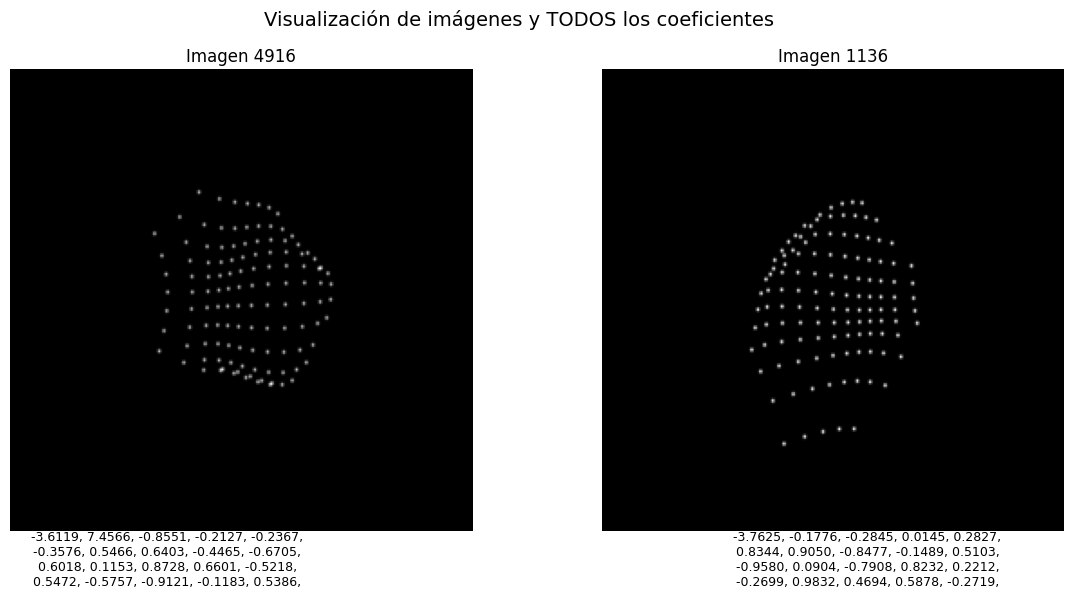

In [8]:
def show_two_images_with_all_coefs(loader):
    to_pil = ToPILImage()

    images, coefs, paths = next(iter(loader))

    img1, img2 = images[0], images[1]
    coef1, coef2 = coefs[0], coefs[1]
    path1, path2 = paths[0], paths[1]

    # Extraer número real de la imagen con regex
    def extract_number(path):
        name = os.path.basename(path)
        # Modificación: Capturar los dígitos que preceden directamente a la extensión .png
        nums = re.findall(r'_(\d+)\.png$', name)
        return int(nums[0]) if nums else -1

    num1 = extract_number(path1)
    num2 = extract_number(path2)

    # Diagnóstico: Imprimir las rutas y los números para verificar
    print(f"Path 1: {path1}, Extracted Number 1: {num1}")
    print(f"Path 2: {path2}, Extracted Number 2: {num2}")

    pil1 = to_pil(img1)
    pil2 = to_pil(img2)

    # Convertir coeficientes a string en varias líneas
    def format_coeffs(c):
        values = c.tolist()
        lines = []
        line = ""
        for i, v in enumerate(values):
            line += f"{v:.4f}, "
            if (i+1) % 5 == 0:   # máx 5 coef por línea
                lines.append(line)
                line = ""
        if line:
            lines.append(line)
        return "\n".join(lines)

    txt1 = format_coeffs(coef1)
    txt2 = format_coeffs(coef2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].imshow(pil1, cmap='gray')
    axes[0].set_title(f"Imagen {num1}")
    axes[0].axis('off')

    axes[1].imshow(pil2, cmap='gray')
    axes[1].set_title(f"Imagen {num2}")
    axes[1].axis('off')

    # Mostrar textos abajo sin traslape
    plt.figtext(0.25, 0.02, txt1, ha='center', fontsize=9)
    plt.figtext(0.75, 0.02, txt2, ha='center', fontsize=9)

    plt.suptitle("Visualización de imágenes y TODOS los coeficientes", fontsize=14)
    plt.show()

    return img1, img2, coef1, coef2

# --- Start of code added to address the IndexError due to batch_size ---
# The CombinedDataset class is defined in cell y2sj-7yNK4yU and should be available.
# However, to properly re-initialize the DataLoader within this cell and address the error,
# we need to ensure its dependencies are correctly set up or re-declared if necessary.

# Define is_valid_number (copied from cell y2sj-7yNK4yU, as CombinedDataset needs it)
def is_valid_number(s):
    """ Verifica si 's' es un número válido, incluyendo notación científica. """
    try:
        float(s)  # Intenta convertir a float
        return True
    except ValueError:
        return False

# Define necessary variables for DataLoader (consistent with y2sj-7yNK4yU and kernel state)
train_pure = './data/DataSet_Zernike_20_Coef/Train'
train_dirs = [train_pure]

# Define transformation (copied from cell y2sj-7yNK4yU)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.Resize((256, 256)), # Ensure consistent image size
    transforms.ToTensor()
])

# Re-define batch_size (from kernel state)
batch_size = 32

# Re-create the training dataset and loader with the correct batch_size
train_dataset = CombinedDataset(train_dirs, transform=transform)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size, # This is the crucial fix for the IndexError
    shuffle=True,
)
# --- End of added code ---

# Ejecutar

img1, img2, coef1, coef2 = show_two_images_with_all_coefs(train_loader)

### Verificación del Tamaño de la Imagen

Este bloque de código simple imprime las dimensiones (forma del tensor) de las dos imágenes (`img1` y `img2`) que se obtuvieron del `DataLoader` en el bloque anterior. Esto es útil para confirmar que las transformaciones de la imagen se aplicaron correctamente y que las imágenes tienen el tamaño esperado (en este caso, `[1, 256, 256]`, lo que indica 1 canal, 256 píxeles de alto y 256 píxeles de ancho).

In [9]:
#tamaño de la imagen
print(f"Tamaño de la imagen 1: {img1.shape}")
print(f"Tamaño de la imagen 2: {img2.shape}")

Tamaño de la imagen 1: torch.Size([1, 256, 256])
Tamaño de la imagen 2: torch.Size([1, 256, 256])


### Visualización de Imágenes Originales y sus Propiedades

Este bloque de código tiene como objetivo mostrar dos imágenes directamente desde el conjunto de datos de entrenamiento (`train_dataset`) en su formato original, es decir, *antes* de que se les aplique cualquier transformación (como redimensionamiento o conversión a tensor). Para cada imagen, se imprimirá su tamaño (ancho y alto en píxeles) y el número de canales, lo que permite verificar las dimensiones iniciales y la estructura de color de las imágenes de entrada.

Esto es útil para entender cómo son las imágenes brutas antes de que el pipeline de preprocesamiento las prepare para el modelo.

Imagen Original 1: Tamaño (1280, 1024), Canales L
Imagen Original 2: Tamaño (1280, 1024), Canales L


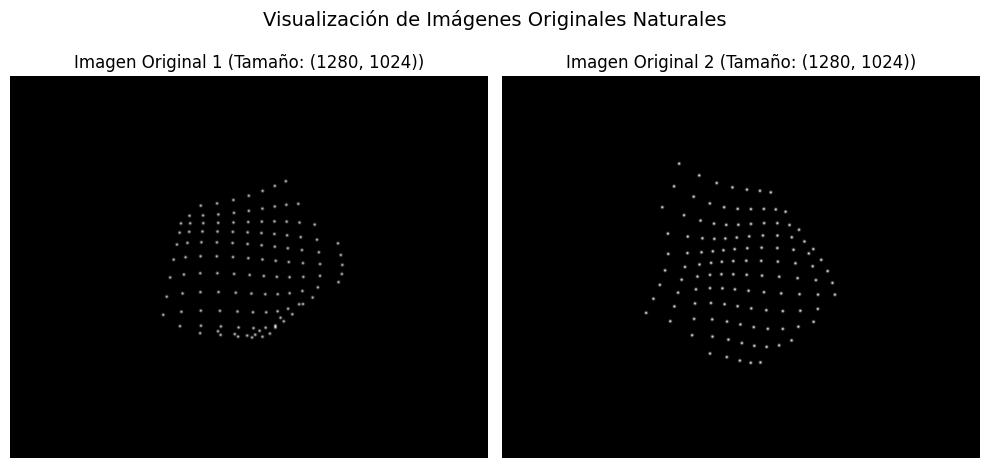

In [10]:
# Asegurémonos de que el train_dataset esté disponible
if 'train_dataset' not in locals():
    # Re-definir las dependencias si no existen en el scope actual
    def is_valid_number(s):
        try:
            float(s)
            return True
        except ValueError:
            return False
    train_pure = './data/DataSet_Zernike_20_Coef/Train'
    train_dirs = [train_pure]
    # Para imágenes originales, no necesitamos transformaciones que cambien el tamaño, solo cargar
    transform_original = transforms.Compose([
        transforms.Grayscale(num_output_channels = 1)
    ])
    train_dataset = CombinedDataset(train_dirs, transform=transform_original)

# Obtener dos imágenes originales directamente del dataset
# Usamos índices diferentes para asegurar imágenes distintas
img_path_orig1, _ = train_dataset.samples[2] # Tomar una tercera imagen del dataset y su coef_path
img_path_orig2, _ = train_dataset.samples[3] # Tomar una cuarta imagen del dataset y su coef_path

image_orig1 = Image.open(img_path_orig1).convert('L') # Cargar y convertir a escala de grises
image_orig2 = Image.open(img_path_orig2).convert('L') # Cargar y convertir a escala de grises

# Imprimir tamaño y canales
print(f"Imagen Original 1: Tamaño {image_orig1.size}, Canales {image_orig1.mode}")
print(f"Imagen Original 2: Tamaño {image_orig2.size}, Canales {image_orig2.mode}")

# Mostrar las imágenes originales
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image_orig1, cmap='gray')
axes[0].set_title(f"Imagen Original 1 (Tamaño: {image_orig1.size})")
axes[0].axis('off')

axes[1].imshow(image_orig2, cmap='gray')
axes[1].set_title(f"Imagen Original 2 (Tamaño: {image_orig2.size})")
axes[1].axis('off')

plt.suptitle("Visualización de Imágenes Originales Naturales", fontsize=14)
plt.tight_layout()
plt.show()